# 📈📉📊프로젝트 : 주식 예측에 도전해 보자

In [1]:
import pandas
import sklearn
import statsmodels
import warnings
warnings.filterwarnings('ignore')

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.4.2
1.1.1
0.13.2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
!ls ../data

005930.KS.csv       house_prices        item_entry_data.csv submission
entry_data.csv      item_data.csv       sales_data.csv


## STEP 1 : 시계열 데이터 준비

In [4]:
ts = pd.read_csv('../data/005930.KS.csv', index_col = 'Date', parse_dates=True)
ts.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


## STEP 2 : 각종 전처리 수행

In [5]:
# Series로 dataframe 분해

ts_open = ts['Open']
ts_high = ts['High']
ts_low = ts['Low']
ts_close = ts['Close']
ts_adc = ts['Adj Close']
ts_v = ts['Volume']


In [6]:
# 빠르게 처리하기 위해 series를 list에 저장

ts_all  = [ts_open, ts_high, ts_low, ts_close, ts_adc, ts_v]
# ts_all  = [ts_close]

In [7]:
for i in ts_all :
    print(i.shape)

(250,)
(250,)
(250,)
(250,)
(250,)
(250,)


In [8]:
# interpolation으로 결측값 채우기
for i in ts_all :
    i.interpolate(method='time', inplace=True)


In [9]:
# 결측치 재확인

for i in ts_all :
    print(f'{i._name} : {i.isna().sum()}')

Open : 0
High : 0
Low : 0
Close : 0
Adj Close : 0
Volume : 0


In [10]:
#로그 변환

ts_close = np.log(ts_close)
ts_open = np.log(ts_open)
ts_high = np.log(ts_high )
ts_low = np.log(ts_low)
ts_adc = np.log(ts_adc)
ts_v = np.log(ts_v)

## STEP 3 : 시계열 안정성 분석

In [11]:
#정성적 그래프 분석

def plot_rolling_statistics(timeseries, window=12) :
    
    roll_mean = timeseries.rolling(window=window).mean()
    roll_std = timeseries.rolling(window=window).std()
    
    orginal = plt.plot(timeseries, color='blue', label='original')
    mean = plt.plot(roll_mean, color='red', label='mean')
    std = plt.plot(roll_std, color='green', label='std')
    
    plt.legend(loc='best')
    plt.title(f'{timeseries._name} : Rolling Mean & STD')
    plt.show(block=False)
    

## 3.1. 정성적 그래프 분석

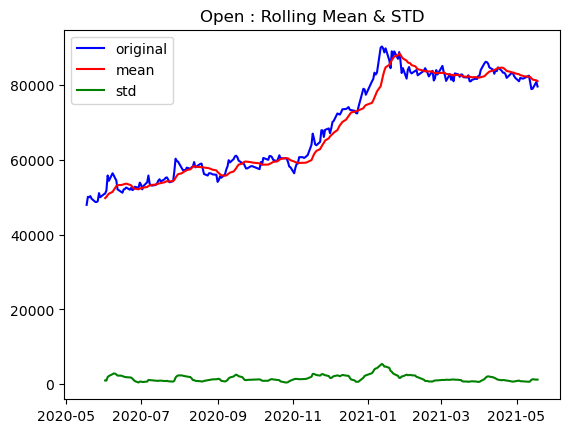

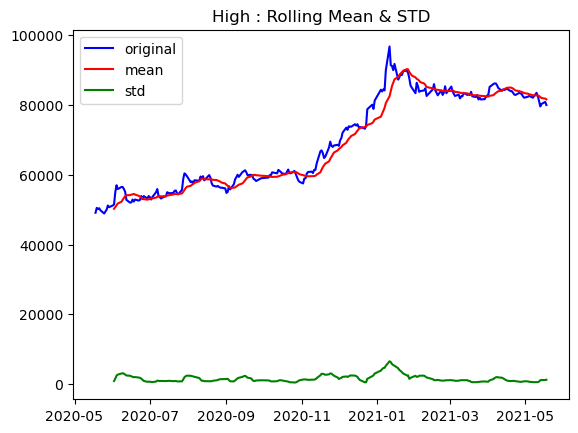

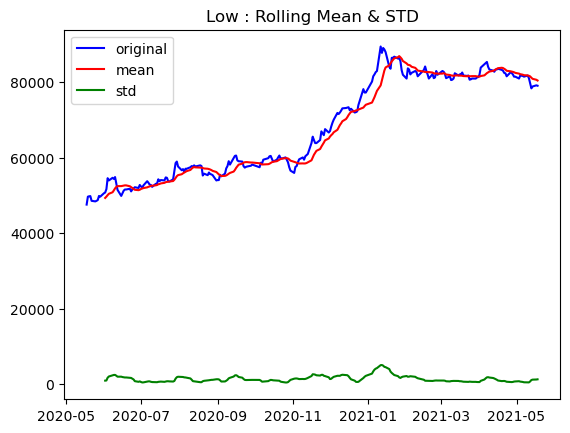

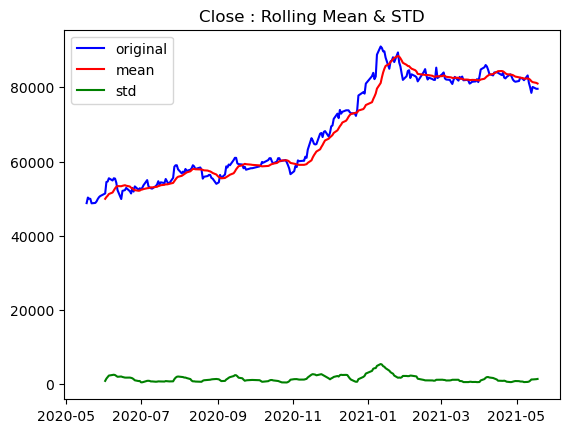

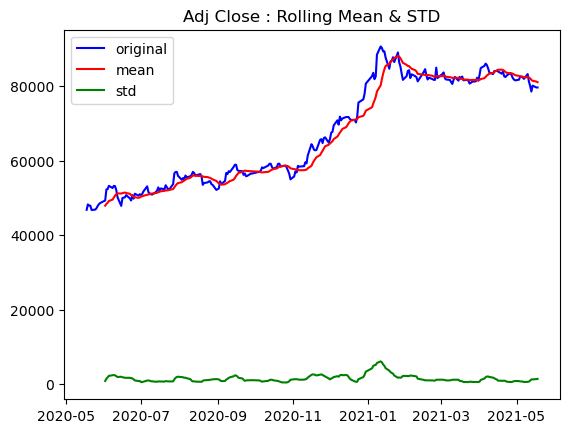

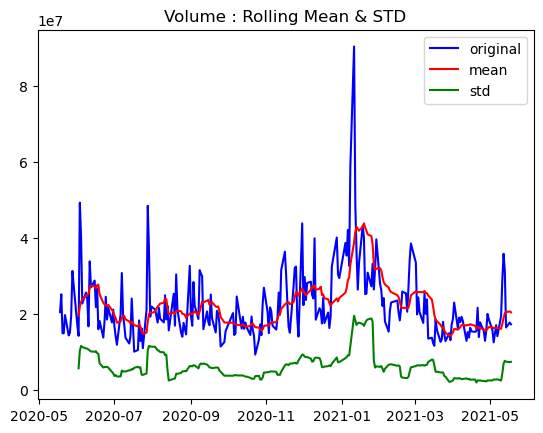

In [12]:
for i in ts_all:
    plot_rolling_statistics(i, window=12)

In [13]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    

## 3.2. Augmented Dicky-Fuller Test

In [14]:
for i in ts_all :
    print('TimeSeries : ', i._name)
    adf_test(i)
    print()

TimeSeries :  Open
Results of Dickey-Fuller Test:
Test Statistic                  -1.315813
p-value                          0.621907
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64

TimeSeries :  High
Results of Dickey-Fuller Test:
Test Statistic                  -1.273216
p-value                          0.641335
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64

TimeSeries :  Low
Results of Dickey-Fuller Test:
Test Statistic                  -1.257365
p-value                          0.648445
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)  

## 3.3. 시계열 분해(Time Series Decomposition)

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

def decomposition_ts(timeseries) :
    decomposition = seasonal_decompose(timeseries, model = 'multiplicative', period =30)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    residual =residual.dropna()
    return adf_test(residual)

## 3.4. Residual 안정성 확인

In [16]:
for i in ts_all :
    print('TimeSeries : ', i._name)
    decomposition_ts(i)
    print()

TimeSeries :  Open
Results of Dickey-Fuller Test:
Test Statistic                -6.047346e+00
p-value                        1.302276e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64

TimeSeries :  High
Results of Dickey-Fuller Test:
Test Statistic                -5.976779e+00
p-value                        1.879310e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64

TimeSeries :  Low
Results of Dickey-Fuller Test:
Test Statistic                -6.208428e+00
p-value                        5.583702e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)        

# STEP 4 : 학습, 테스트 데이터셋 생성

In [17]:
def split_train_test_set(timeseries):
    train_data, test_data = timeseries[:int(len(timeseries)*0.9)], timeseries[int(len(timeseries)*0.9):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(timeseries, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()

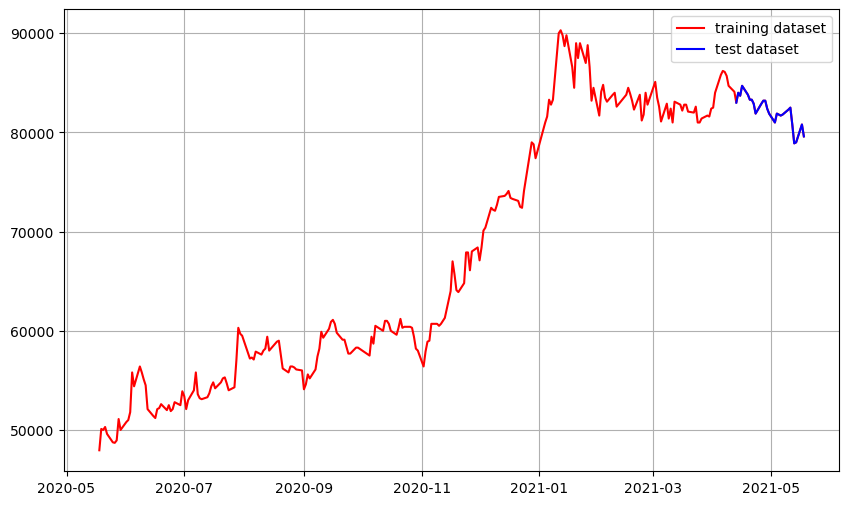

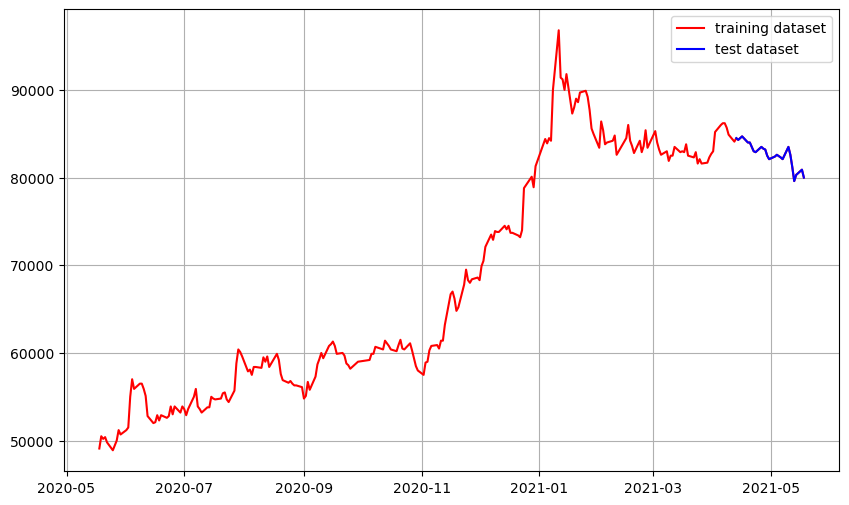

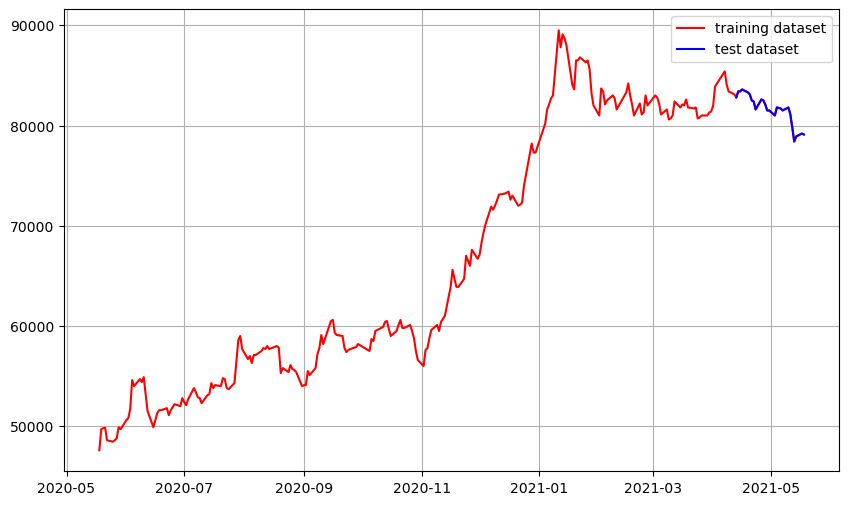

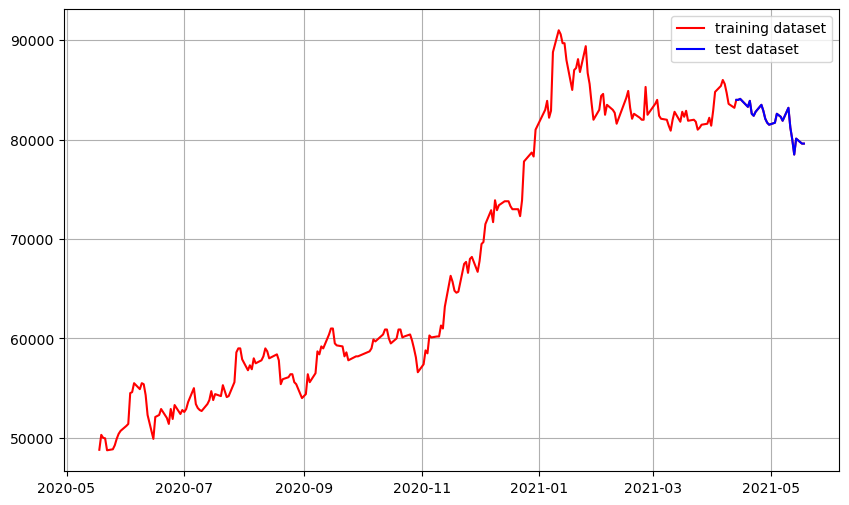

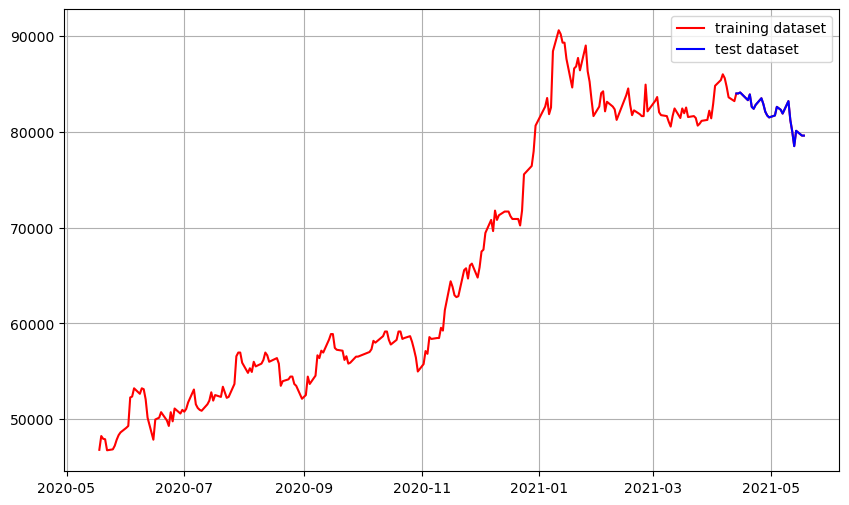

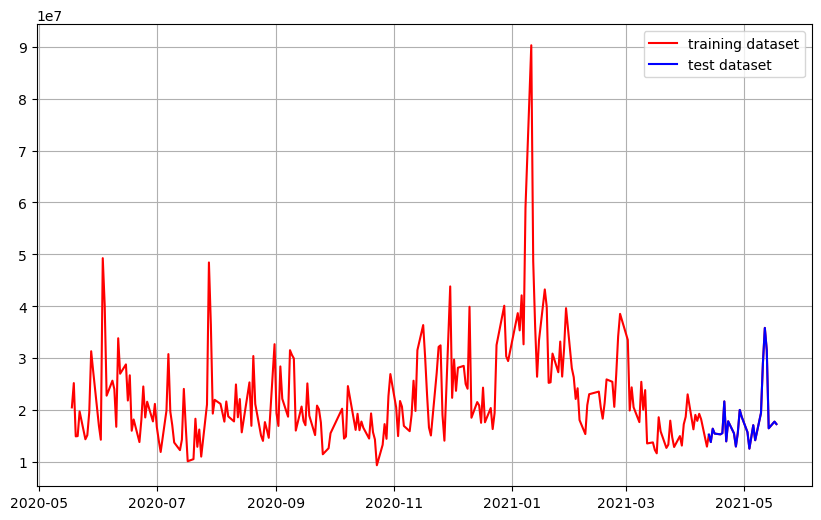

In [18]:
for i in ts_all :
    split_train_test_set(i)

# STEP 5 : 적정 ARIMA 모수 찾기 

## 5.1. ACF & PACF

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [20]:
def plot_acf_pacf(timeseries):
    plot_acf(timeseries)
    plot_pacf(timeseries)
    plt.show()

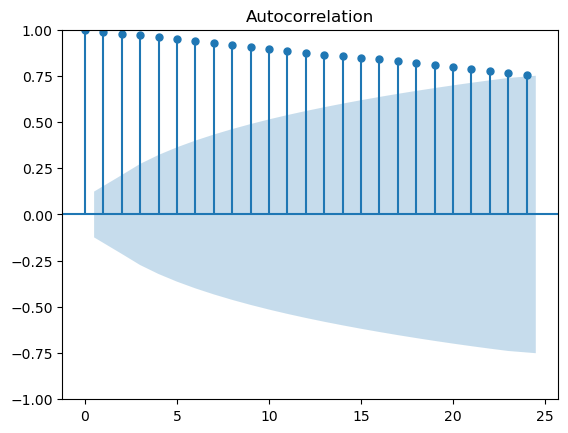

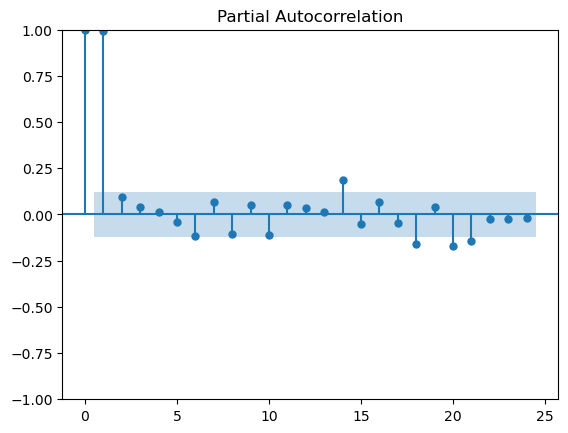

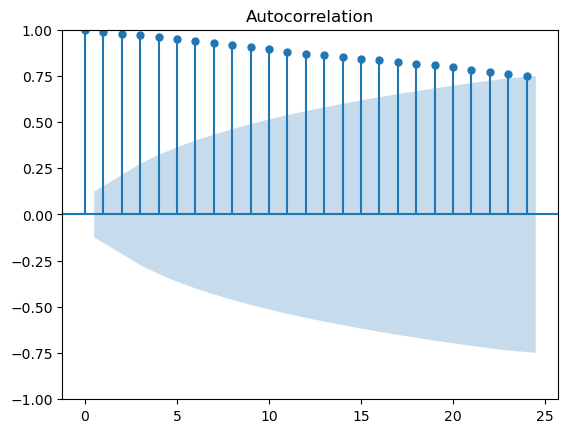

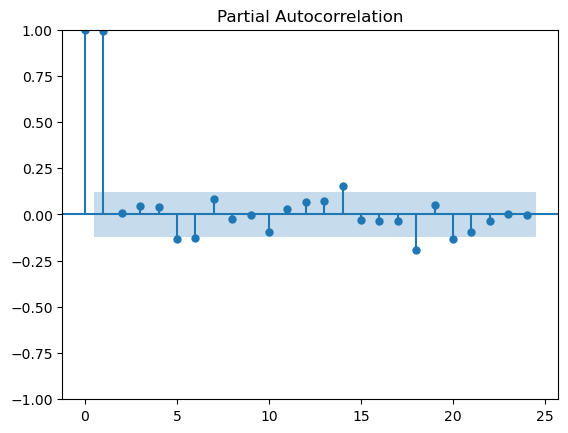

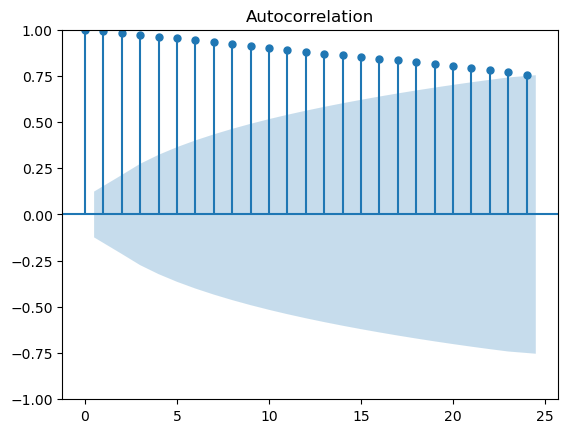

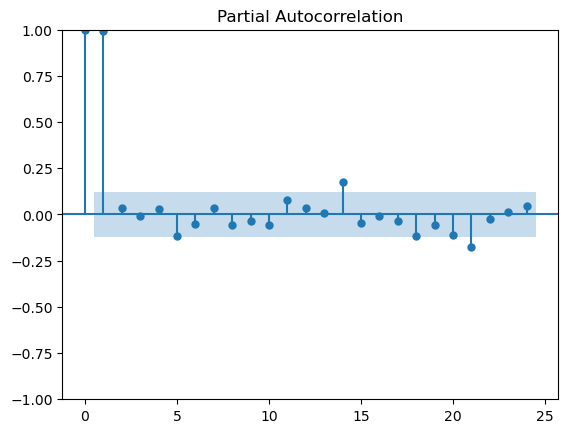

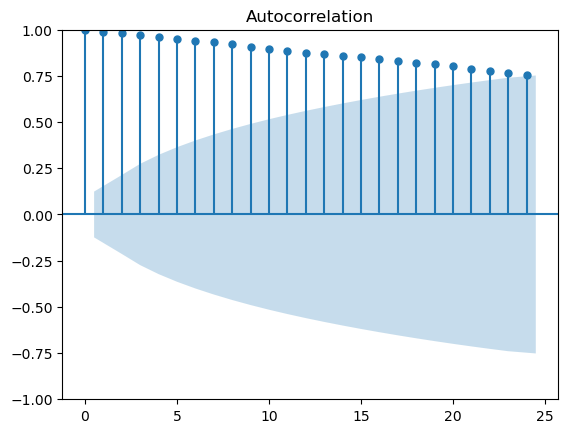

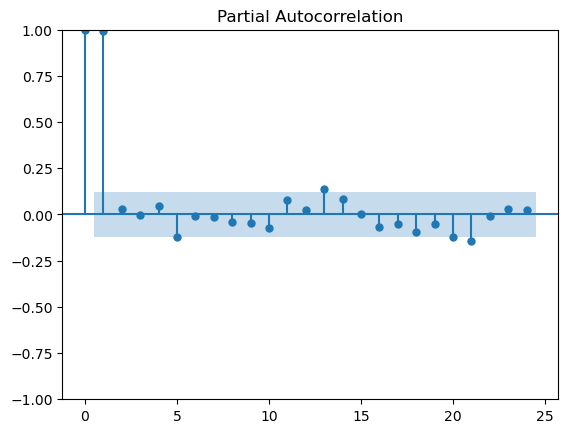

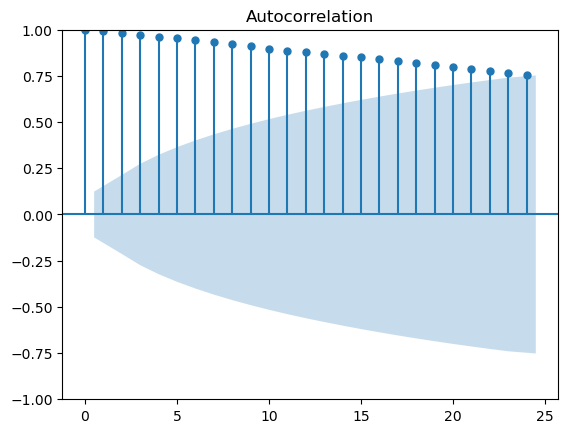

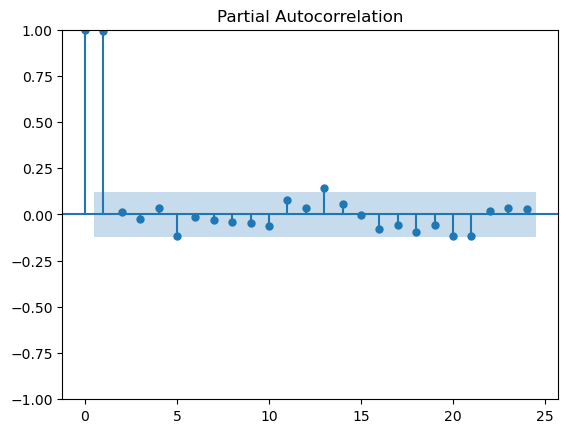

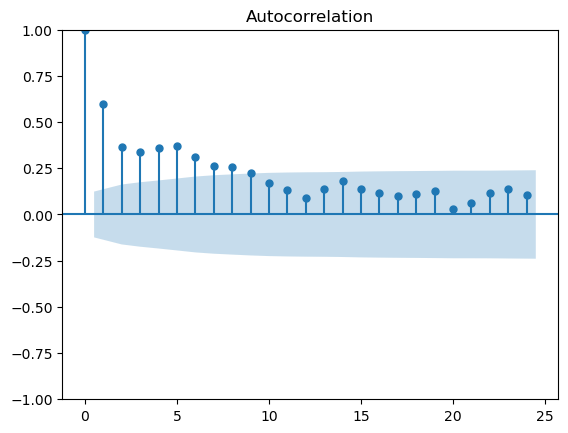

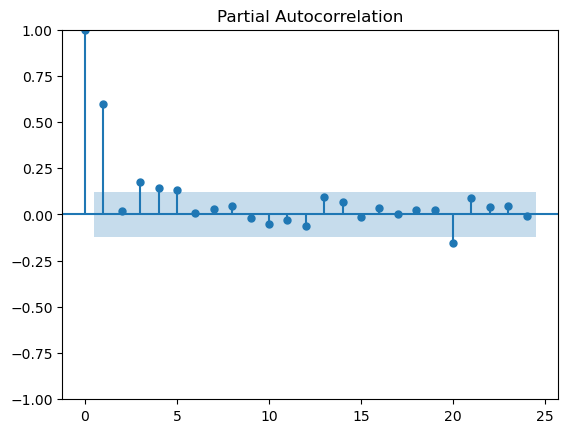

In [21]:
for i in ts_all :
    plot_acf_pacf(i)

## 5.2. differencing

In [22]:
def diff_check(timeseries):
    diff_1 = timeseries.diff(periods=1).iloc[1:]
    diff_1.plot(title='difference 1st')
    plt.show()
    
    print(timeseries._name)
    adf_test(diff_1)
    
    diff_2 = diff_1.diff(periods=1).iloc[1:]
    diff_2.plot(title='difference 2st')
    plt.show()
    print()
    adf_test(diff_2)
    print()

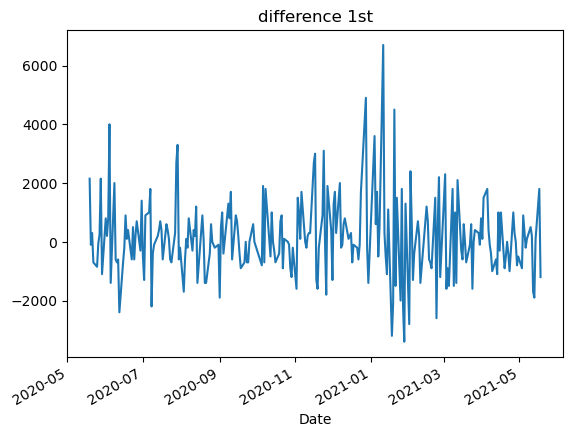

Open
Results of Dickey-Fuller Test:
Test Statistic                -1.726138e+01
p-value                        5.938317e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


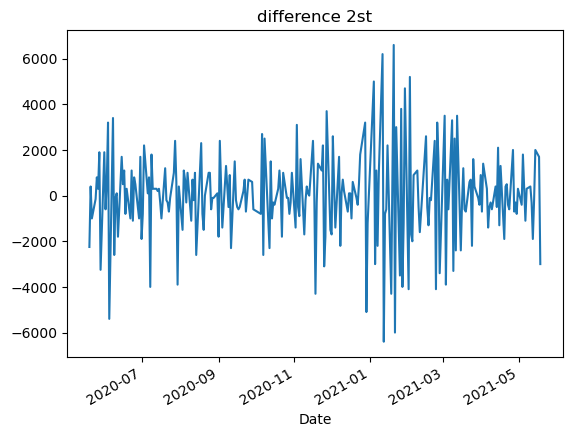


Results of Dickey-Fuller Test:
Test Statistic                -1.090419e+01
p-value                        1.139107e-19
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64



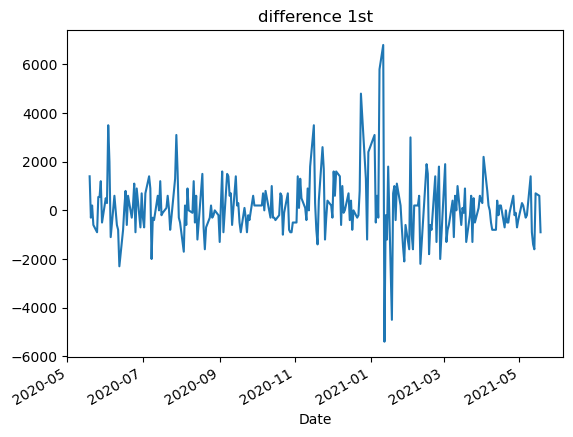

High
Results of Dickey-Fuller Test:
Test Statistic                -6.768628e+00
p-value                        2.677001e-09
#Lags Used                     5.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64


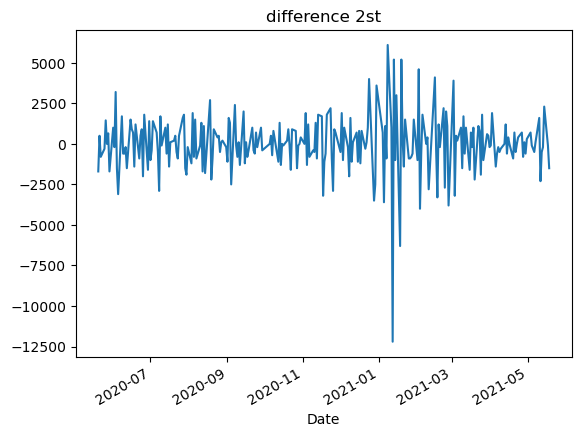


Results of Dickey-Fuller Test:
Test Statistic                -7.028665e+00
p-value                        6.267684e-10
#Lags Used                     1.500000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64



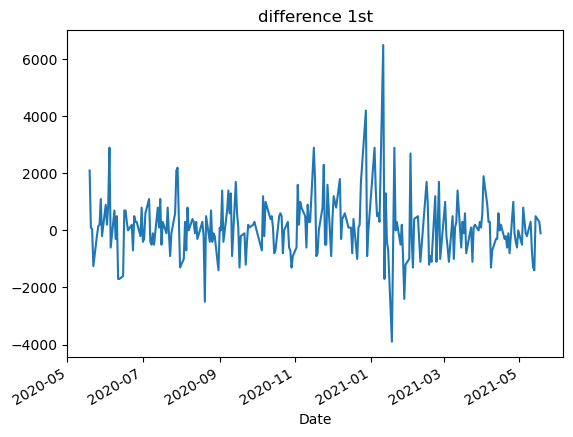

Low
Results of Dickey-Fuller Test:
Test Statistic                -1.488879e+01
p-value                        1.568743e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


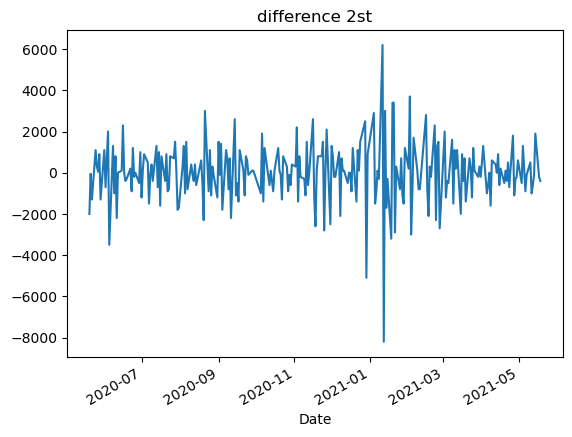


Results of Dickey-Fuller Test:
Test Statistic                -1.030374e+01
p-value                        3.320194e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64



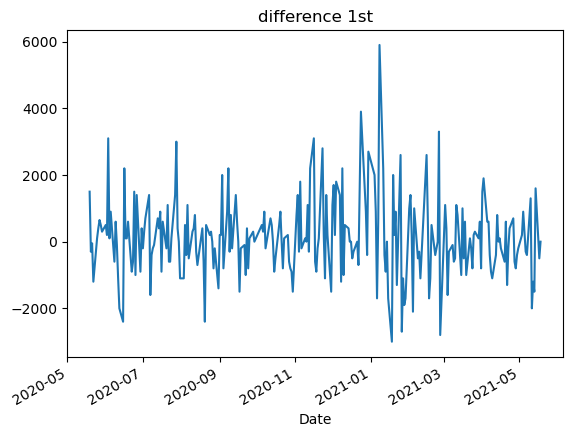

Close
Results of Dickey-Fuller Test:
Test Statistic                -1.541059e+01
p-value                        3.127307e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


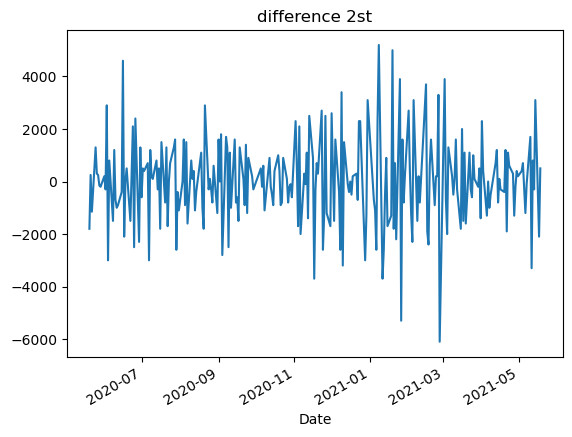


Results of Dickey-Fuller Test:
Test Statistic                -1.073769e+01
p-value                        2.870899e-19
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64



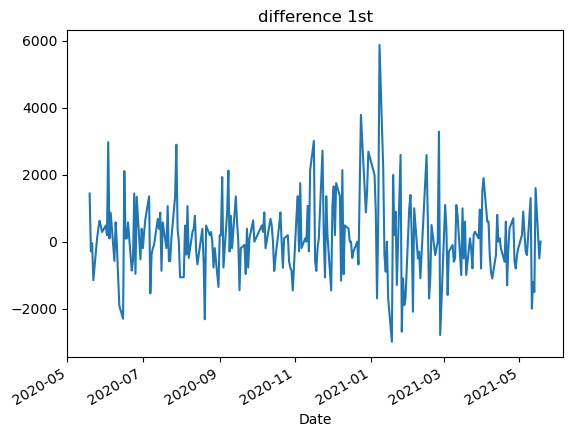

Adj Close
Results of Dickey-Fuller Test:
Test Statistic                -1.511946e+01
p-value                        7.496378e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


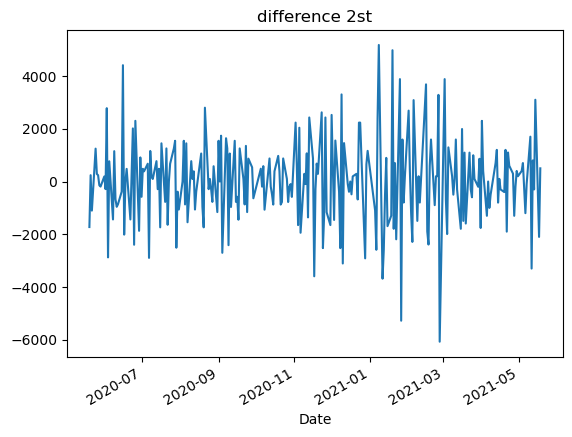


Results of Dickey-Fuller Test:
Test Statistic                -1.046216e+01
p-value                        1.350328e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64



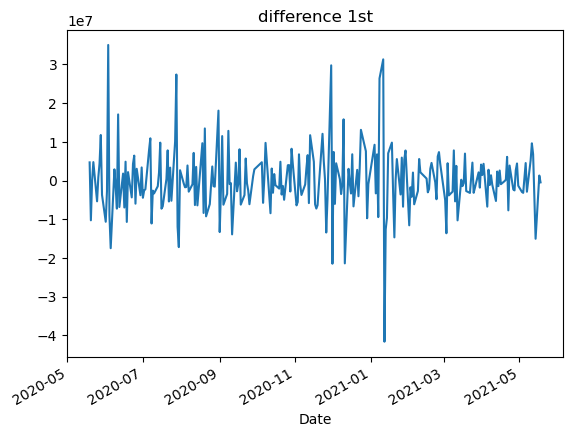

Volume
Results of Dickey-Fuller Test:
Test Statistic                -1.268216e+01
p-value                        1.180558e-23
#Lags Used                     3.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


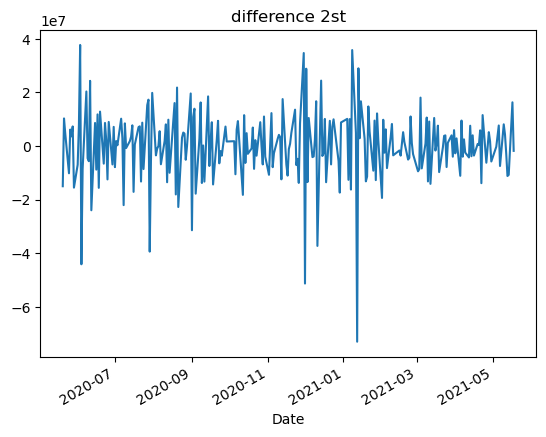


Results of Dickey-Fuller Test:
Test Statistic                -1.013888e+01
p-value                        8.524272e-18
#Lags Used                     9.000000e+00
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64



In [23]:
for i in ts_all:
    diff_check(i)

# STEP 6 : ARIMA 모델 훈련과 테스트

## 6.1. 모델 생성

In [24]:
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore')

In [25]:
def fit_arima(timeseries):
    train_data = timeseries[:int(len(timeseries) *0.9)]
    model = ARIMA(train_data, order = (14,1,0))
    fitted_m = model.fit()

    print(fitted_m.summary())

In [26]:
for i in ts_all :
    fit_arima(i)

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  225
Model:                ARIMA(14, 1, 0)   Log Likelihood               -1928.935
Date:                Fri, 11 Nov 2022   AIC                           3887.871
Time:                        16:59:33   BIC                           3939.045
Sample:                             0   HQIC                          3908.527
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0232      0.034      0.685      0.494      -0.043       0.089
ar.L2         -0.0004      0.062     -0.007      0.994      -0.122       0.121
ar.L3          0.0153      0.055      0.280      0.7

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(14, 1, 0)   Log Likelihood               -1903.666
Date:                Fri, 11 Nov 2022   AIC                           3837.331
Time:                        16:59:37   BIC                           3888.506
Sample:                             0   HQIC                          3857.988
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0516      0.061      0.843      0.399      -0.068       0.172
ar.L2         -0.0219      0.075     -0.290      0.772      -0.170       0.126
ar.L3         -0.0069      0.066     -0.104      0.9

## 6.2. Forecasting

In [27]:
def forecast_arima(timeseries):
    train_data, test_data = timeseries[:int(len(timeseries)*0.9)], timeseries[int(len(timeseries)*0.9):]

    model = ARIMA(train_data ,order=(2,0,1))
    fitted_m = model.fit()
    
    fc = fitted_m.forecast(len(test_data),alpha=0.05)
    fc = np.array(fc)
    fc_series =pd.Series(fc,index=test_data.index)

    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='observed')
    plt.plot(fc_series, c='r', label='predicted')
    plt.legend()
    plt.title(timeseries._name)
    plt.show()

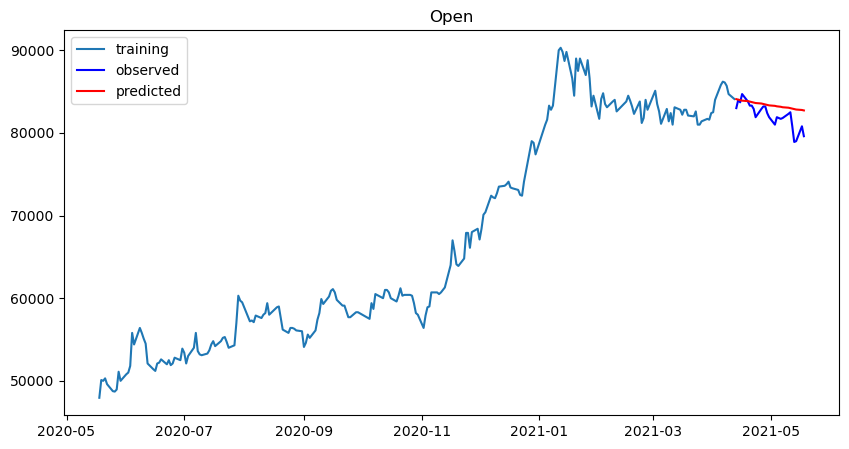

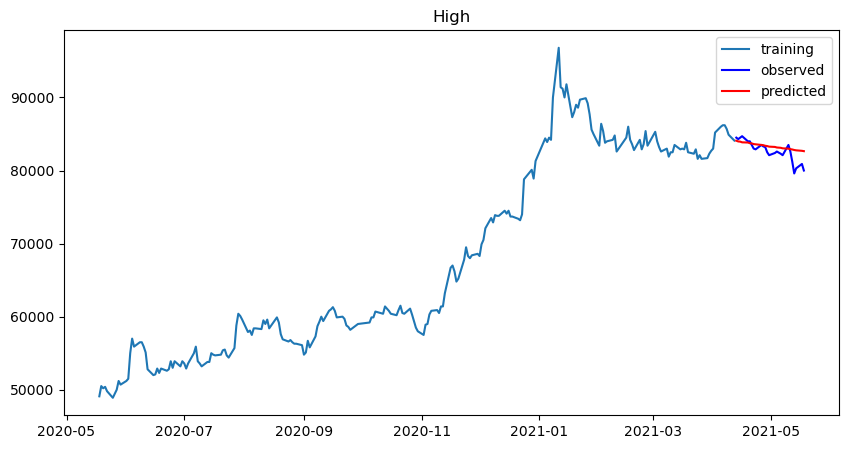

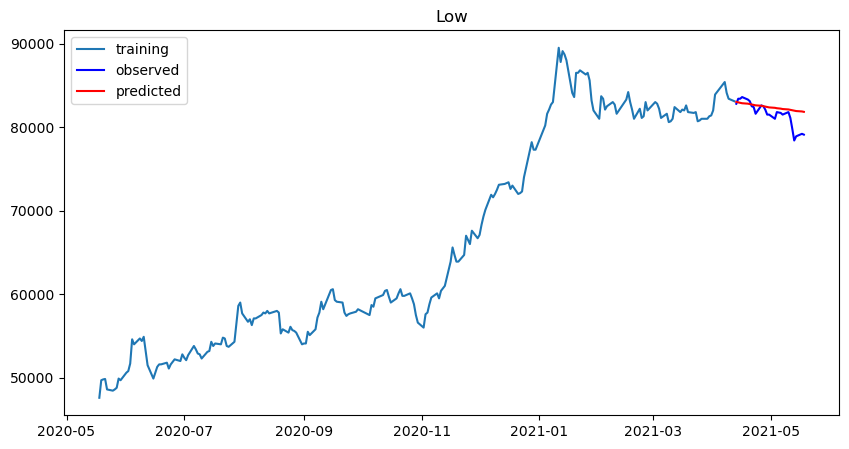

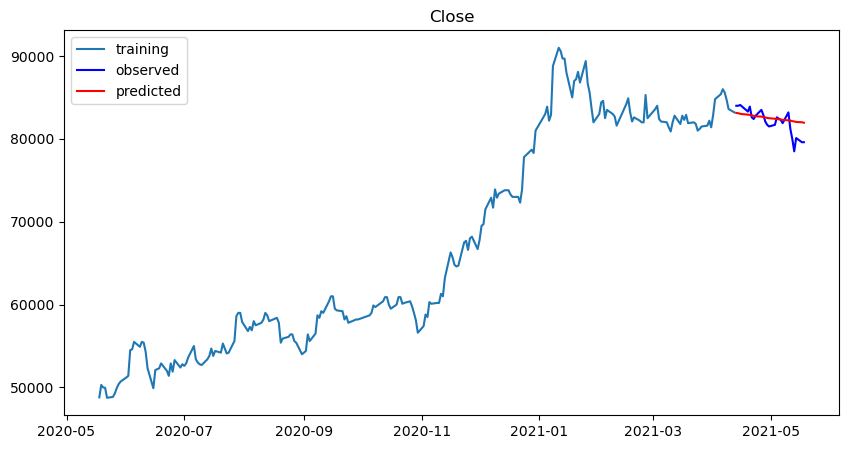

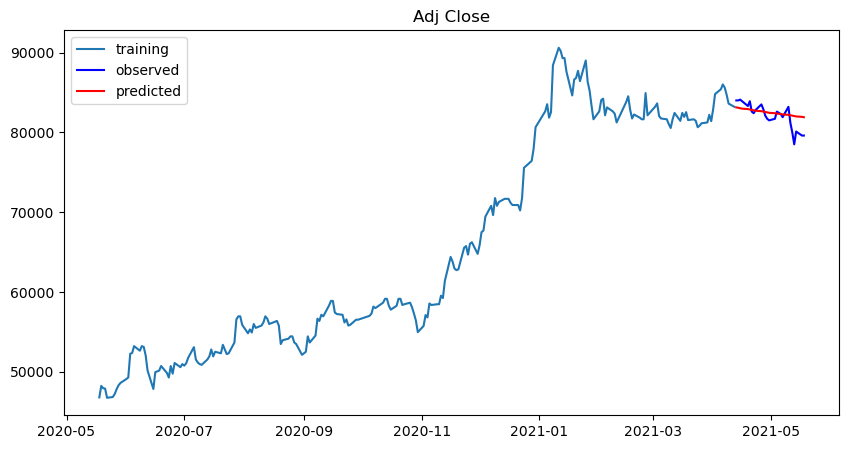

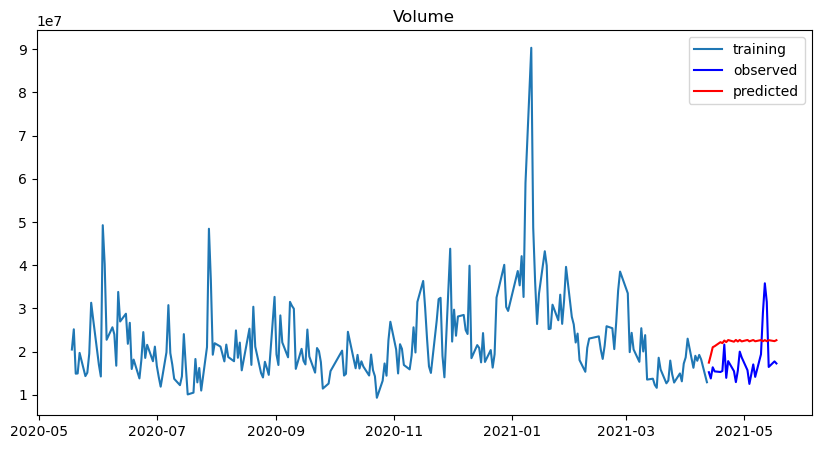

In [28]:
for i in ts_all:
    forecast_arima(i)

## 6.3. evaluating metrics 

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


def evaluate_arima(timeseries):
    print(timeseries._name)
    
    train_data, test_data = timeseries[:int(len(timeseries)*0.9)], timeseries[int(len(timeseries)*0.9):]

    model = ARIMA(train_data ,order=(14,1,0))
    fitted_m = model.fit()
    
    fc = fitted_m.forecast(len(test_data),alpha=0.05)
    fc = np.array(fc)
    
    mse = mean_squared_error( np.exp(test_data) , np.exp(fc) )
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)

    rmse = mse **0.5
    print('RMSE: ', rmse)

    mape = np.mean((abs(np.exp(fc)-np.exp(test_data)) /np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

In [30]:
evaluate_arima(ts_close[np.isfinite(ts_close)])

Close
MSE:  3004578.144342731
MAE:  1233.6509438573949
RMSE:  1733.371900182627
MAPE: 1.53%


# STEP 7 : 다른 주식 종목 예측해 보기

## 7.1. 네이버 

In [31]:
#Naver
ts2 = pd.read_csv('../data/035420.KS.csv')

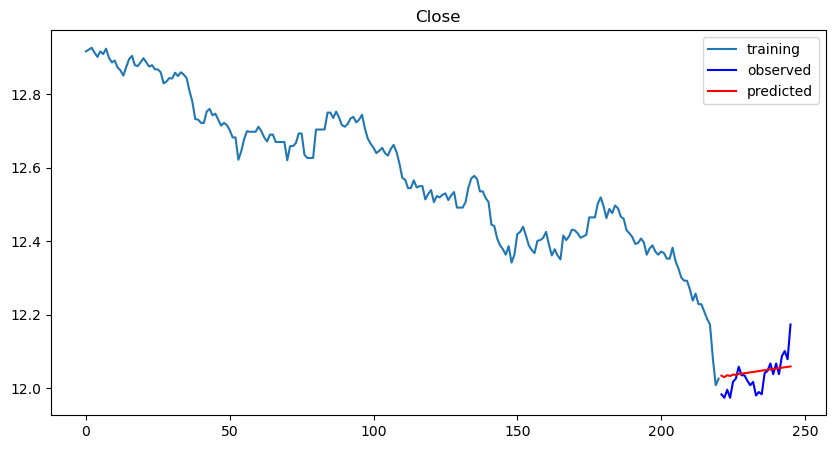

In [41]:
forecast_arima(np.log(ts2['Close']))

In [43]:
evaluate_arima(np.log(ts2['Close']))

Close
MSE:  328148349.09572566
MAE:  15076.216008644076
RMSE:  18114.86541754384
MAPE: 8.72%


## 7.2. 메타

In [33]:
#Meta
ts3 = pd.read_csv('../data/META.csv')

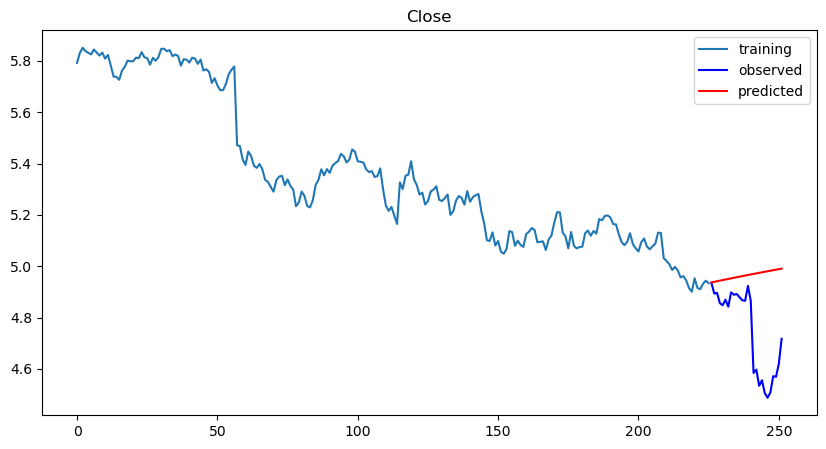

In [44]:
forecast_arima(np.log(ts3['Close']))

In [45]:
evaluate_arima(np.log(ts3['Close']))

Close
MSE:  785.0155634206416
MAE:  21.425125525002905
RMSE:  28.01812919201854
MAPE: 21.41%


## 7.3. 줌

In [37]:
#Zoom 
ts4 = pd.read_csv('../data/ZM.csv')

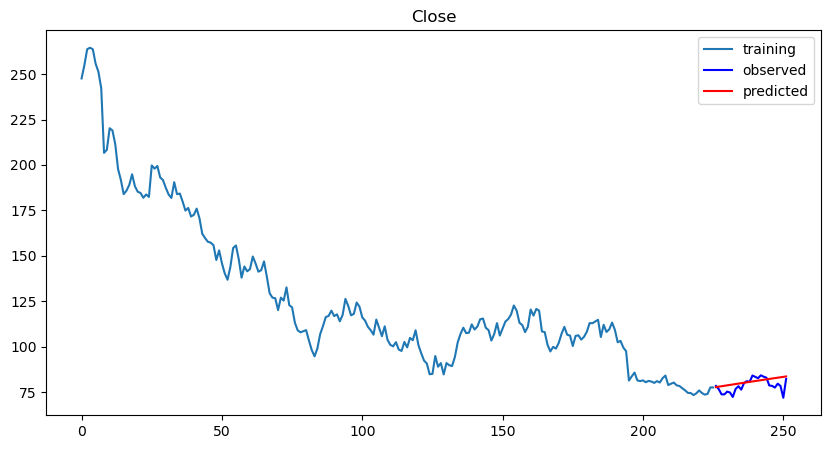

In [38]:
forecast_arima(ts4['Close'])

In [39]:
evaluate_arima(ts4['Close'])

Close
MSE:  1.228281336424799e+72
MAE:  4.987081522080556e+35
RMSE:  1.1082785464064524e+36
MAPE: 7094.04%


## 7.4. Acutus

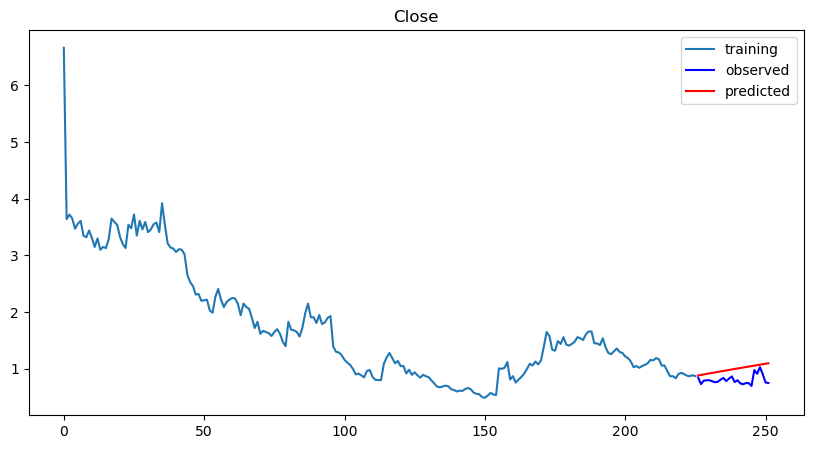

In [46]:
#Acutus Medical.Inc
ts5 = pd.read_csv('../data/AFIB.csv')
forecast_arima(ts5['Close'])

In [47]:
evaluate_arima(ts5['Close'])

Close
MSE:  0.09456188376212264
MAE:  0.2830252654550637
RMSE:  0.307509160452372
MAPE: 12.96%
